In [57]:
using Pkg; Pkg.activate(".")
using Statistics
using PyPlot
using Glob
#using Revise
using DelimitedFiles
using MUST

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/visualize/Project.toml`


In [58]:
MUST.@import_dispatch "../../../dispatch2" 
MUST.@import_dispatch "../../../dispatch2" EOS 
MUST.@get_help visual
pl =pyimport("matplotlib.pylab");

In [59]:
# read the solar model
solar_model = readdlm("solar_model.txt");

In [60]:
#folder            = MUST.@in_dispatch "data_testrun4/grid78_phase1"
folder            = MUST.@in_dispatch "data/stellar_relaxing3"
#folder            = MUST.@in_dispatch "data/grid51_phase1"

folder2           = MUST.@in_dispatch "data/restart_relaxing3"
#folder2            = MUST.@in_dispatch "data/grid51_phase2"
#folder2            = MUST.@in_dispatch "data/restart"

content_of_folder = glob("*/", folder)
snapshots         = sort(MUST.list_of_snapshots(content_of_folder));

content_of_folder2 = glob("*/", folder2)
snapshots2         = sort(MUST.list_of_snapshots(content_of_folder2));

In [61]:
eos_stagger = MUST.@legacyPythonEOS
eos_sqg     = MUST.SquareGasEOS(MUST.@in_dispatch("input_data/square_gas_1"));

In [62]:
units = MUST.StaggerCGS()

MUST.AtmosUnits("cgs", 1.0e8, 1.0e-7, 100.0, 1.0e6, 1.0e17, 100000.0, 0.09999999999999999, 1.0e12, 100000.0, 0.1, 1.0e-8, 1.3, 1120.9982432795857, 1.380658e-16, 1.6726219e-24, 6.65e-24)

In [63]:
function convert_snaps(snapshots, folder)
    boxes = []
    for (i_s,snap) in enumerate(snapshots)
        try
            # The dispatch snapshot object (Python)
            snap = dispatch.snapshot(snapshots[i_s], data=folder)

            # Convert its content to pure Julia
            s = MUST.Space(snap, :d, :ee, :uz, :e)
            
            # Units for conversion to CGS
            units = MUST.StaggerCGS(snap)

            # Apply the conversion to CGS
            MUST.convert!(s, units; d=:d,   ee=:ee, uz=:u,  e=:e, 
                                    x=:l,   y=:l,   z=:l)

            # Lookup and add the columns
            MUST.add_from_EOS!(s, eos_sqg, :T)
            MUST.add_from_EOS!(s, eos_sqg, :kr)
            
            # Also save the snapshot as Box (a regular gridded 3D-cube) to save time later
            b_s = MUST.Box(s)

            # Add the optical depth
            τ = MUST.optical_depth(b_s, opacity=:kr, density=:d)
            MUST.add!(b_s, τ, :τ_ross)

            # Switch the height scale to optical depth (This requires interpolation of the whole cube, ~20s)
            b_s = MUST.height_scale(b_s, :τ_ross);

            # Write to HDF5 file. Can easily be read as a Memory map later with the build in functions
            #MUST.save(s;   name="space_sn$(snapshots[i_s])", folder=folder)
            MUST.save(b_s; name="box_sn$(snapshots[i_s])",   folder=folder)

            append!(boxes, [MUST.Box("box_sn$(snapshots[i_s])", folder=folder)])
        catch
            @warn "sn $(i_s) could not be read."
        end
    end

    boxes
end

convert_snaps (generic function with 1 method)

In [64]:
function read_snaps(snapshots, folder)
    boxes  = []
    boxesT = []
    for (i_s,snap) in enumerate(snapshots)
        try
            # Also save the snapshot as Box (a regular gridded 3D-cube) to save time later
            append!(boxes, [MUST.Box("box_sn$(snapshots[i_s])", folder=folder)])
            append!(boxesT, [MUST.Box("box_tau_sn$(snapshots[i_s])", folder=folder)])
        catch
            @warn "could not load $(i_s)"
        end
    end
    boxes, boxesT
end

read_snaps (generic function with 1 method)

In [65]:
#boxes = convert_snaps(snapshots, folder)
boxes,boxesT = read_snaps(snapshots, folder)
z = boxes[1].z[1,1,:];

┌ Warning: could not load 32
└ @ Main In[64]:10


In [66]:
#boxes2 = convert_snaps(snapshots2, folder2)
boxes2,boxesT2 = read_snaps(snapshots2, folder2)
z2     = boxes2[1].z[1,1,:];

┌ Warning: could not load 1
└ @ Main In[64]:10
┌ Warning: could not load 52
└ @ Main In[64]:10
┌ Warning: could not load 53
└ @ Main In[64]:10
┌ Warning: could not load 54
└ @ Main In[64]:10
┌ Warning: could not load 55
└ @ Main In[64]:10
┌ Warning: could not load 56
└ @ Main In[64]:10


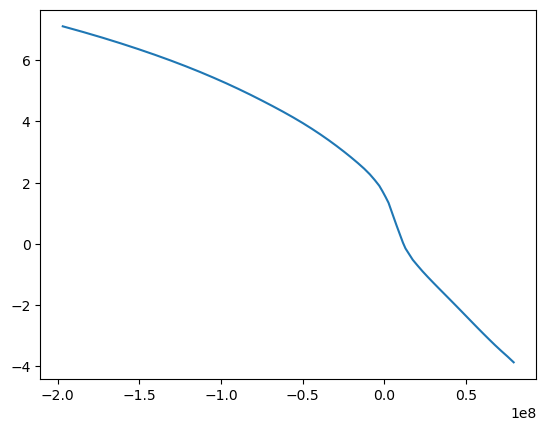

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2b11993839a0>

In [67]:
plt.plot(boxesT2[1].z[1,1,:],boxesT2[1][:τ_ross][1,1,:])

In [68]:
#gif_by_value(mean, folder, "logτ = 0",  variable=:T, clabel="T [K]", duration=0.2, τ_ross=0.0, path_ext="zp00_nort", cmap="hot")
#gif_by_value(mean, folder2, "z 0 surface", variable=:T, duration=0.35, τ_ross=0.0, path_ext="zp00_rt", cmap="hot")
#gif_by_value(mean, folder, "top",         variable=:uz, duration=0.35, z=0.5,   path_ext="zp05", cmap="hot", vmin=-1,  vmax=1)
#gif_by_value(mean, folder, "inter",       variable=:ee, duration=0.35, z=0.125, path_ext="zp13", cmap="hot", vmin=5.15, vmax=5.55)
#gif_by_value(folder, "bottom", variable=:uz, duration=0.35, z=-1.5e8,  path_ext="zm15", cmap="hot", vmin=0, vmax=20) do x
#    mean(x ./ 1e5)
#end

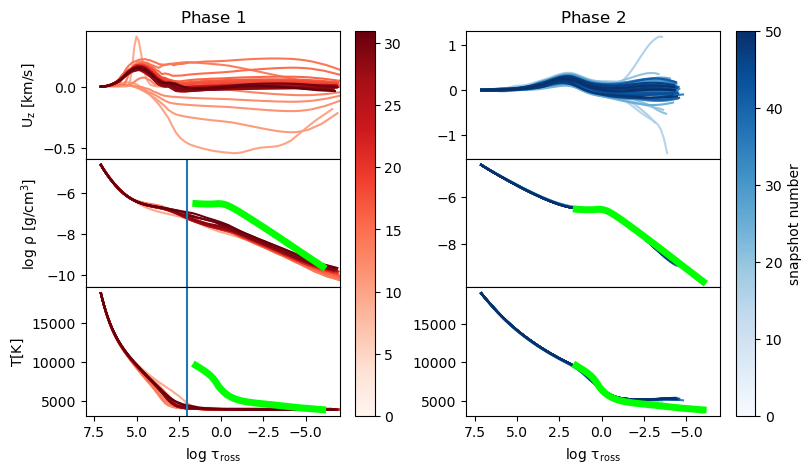

PyObject <matplotlib.lines.Line2D object at 0x2b1458f73f10>

In [69]:
f,ax = plt.subplots(3,2, sharex=true, figsize=(9,5))

plt.subplots_adjust(hspace=0)

filenames = String[]

colors = pl.cm.Reds.(Vector(range(0.3,1.0; length=length(boxes))))
sm     = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=length(boxes)))
plt.colorbar(sm, ax=ax[:,1])

colors2 = pl.cm.Blues.(Vector(range(0.3,1.0; length=length(boxes2))))
sm2     = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=length(boxes2)))
cbar = plt.colorbar(sm2, ax=ax[:,2])
cbar.set_label("snapshot number")

#ax[1,2].set_ylim(-0.6736407617187501, 13.025547381103516); ax[1,1].set_ylim(-0.6736407617187501, 13.025547381103516)
#ax[2,2].set_ylim(-27.58334445953369, -9.9887113571167)   ; ax[2,1].set_ylim(-27.58334445953369, -9.9887113571167)
#ax[3,2].set_ylim(3.5e12, 1.10747040350208e13); ax[3,1].set_ylim(3.5e12, 1.10747040350208e13)

ax[2,2].set_xlim(8,-7)

ax[1,1].set_ylabel(L"\rm U_z\ [km/s]")
ax[2,1].set_ylabel(L"\rm \log\ \rho\ [g/cm^3]")
ax[3,1].set_ylabel(L"\rm T [K]")

ax[3,1].set_xlabel(L"\rm \log\ \tau_{ross}\ ")
ax[3,2].set_xlabel(L"\rm \log\ \tau_{ross}\ ")

ax[1,1].set_title(L"\rm Phase\ 1")
ax[1,2].set_title(L"\rm Phase\ 2")


for i in 1:length(boxes)
    v  = MUST.plane_statistic(mean, boxesT[i], :uz) .* 1e-5
    zs = boxes[i].z[1,1,:]
    t  = boxes[i][:τ_ross][1,1,:]
    ax[1,1].plot(t, v, label="$(i)", color=colors[i])

    v  = MUST.plane_statistic(mean, boxesT[i], :d) 
    zs = boxes[i].z[1,1,:]
    t  = boxes[i][:τ_ross][1,1,:]
    ax[2,1].plot(t, log10.(v), label="$(i)", color=colors[i])

    #v  = MUST.plane_statistic(maximum, boxesT[i], :d) 
    #zs = boxes[i].z[1,1,:]
    #ax[2,1].plot(zs, log10.(v), label="$(i)", color=colors[i])

    v  = MUST.plane_statistic(mean, boxesT[i], :T) 
    zs = boxes[i].z[1,1,:]
    t  = boxes[i][:τ_ross][1,1,:]
    ax[3,1].plot(t, v, label="$(i)", color=colors[i])

    append!(filenames, ["b1b2_$(i).png"])
    #f.savefig("b1b2_$(i).png")
    
    #i==1 && f.savefig("ini_snap.png") 
end

for i in 1:length(boxesT2)
    v  = MUST.plane_statistic(mean, boxesT2[i], :uz) .* 1e-5
    zs = boxesT2[i].z[1,1,:]
    t  = boxesT2[i][:τ_ross][1,1,:]
    ax[1,2].plot(t, v, label="$(i)", color=colors2[i])

    v  = MUST.plane_statistic(mean, boxesT2[i], :d) 
    zs = boxesT2[i].z[1,1,:]
    t  = boxesT2[i][:τ_ross][1,1,:]
    ax[2,2].plot(t, log10.(v), label="$(i)", color=colors2[i])

    v  = MUST.plane_statistic(mean, boxesT2[i], :T) 
    zs = boxesT2[i].z[1,1,:]
    t  = boxesT2[i][:τ_ross][1,1,:]
    ax[3,2].plot(t, v, label="$(i)", color=colors2[i])

    append!(filenames, ["b1b2_$(length(boxes)+i).png"])
    #f.savefig("b1b2_$(length(boxes)+i).png")
end

#=lim!(a,b) = begin
    lima = a.get_ylim()
    limb = b.get_ylim()
    limm = (min(lima[1],limb[1]), max(lima[2],limb[2]))
    a.set_ylim(limm...)
    b.set_ylim(limm...)
end=#

ax[2,1].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
ax[3,1].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)

ax[2,2].plot(solar_model[:,2], solar_model[:,end], color="lime", lw=5)
ax[3,2].plot(solar_model[:,2], solar_model[:,3], color="lime", lw=5)

ax[2,1].axvline(2)
ax[3,1].axvline(2)
#=
lim!(ax[1,2], ax[1,1])
lim!(ax[2,2], ax[2,1])
lim!(ax[3,2], ax[3,1])

@show ax[1,2].get_ylim()
@show ax[2,2].get_ylim()
@show ax[3,2].get_ylim()
=#

#gif_from_pngs(filenames, "phase_summary_Squaregas.gif")


In [70]:
t    = getfield.(getfield.(boxesT2,:parameter), :time)
temp = getfield.(getfield.(boxesT2,:parameter), :teff);

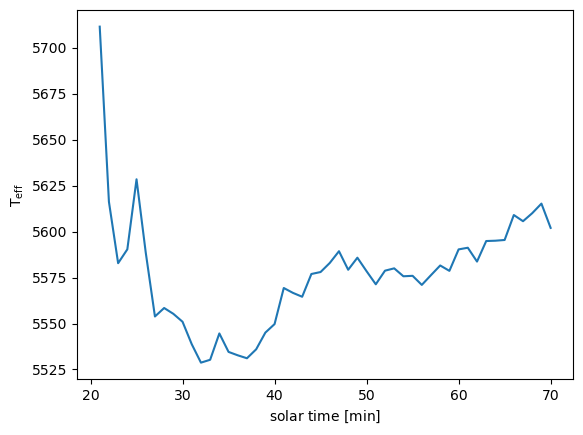

PyObject Text(0.5, 26.28125, '$\\rm solar\\ time\\ [min]$')

In [71]:
plt.plot(t,temp)
plt.ylabel(L"\rm T_{eff}")
plt.xlabel(L"\rm solar\ time\ [min]")

In [72]:
i_min = argmin(abs.(solar_model[:,2] .- 0))
solar_model[i_min,:]

8-element Vector{Float64}:
   58.0
   -0.02308
 6422.082031
   -6.670915
    1.769931
    5.097679
    5.097679
   -6.530671

In [73]:
b0 = MUST.reduce_by_value(mean, boxesT2[end], τ_ross=0.0);

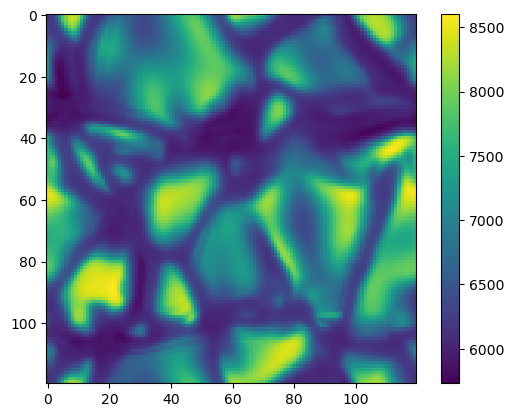

PyObject <matplotlib.colorbar.Colorbar object at 0x2b1458b3fbb0>

In [74]:
plt.imshow(b0[:T][:,:,1])
plt.colorbar()